[[ 0.66666667  0.          0.          0.         -0.33333333  0.
   0.          0.         -0.33333333]
 [ 0.          0.5         0.          0.5         0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.5         0.          0.          0.
   0.5         0.          0.        ]
 [ 0.          0.5         0.          0.5         0.          0.
   0.          0.          0.        ]
 [-0.33333333  0.          0.          0.          0.66666667  0.
   0.          0.         -0.33333333]
 [ 0.          0.          0.          0.          0.          0.5
   0.          0.5         0.        ]
 [ 0.          0.          0.5         0.          0.          0.
   0.5         0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.5
   0.          0.5         0.        ]
 [-0.33333333  0.          0.          0.         -0.33333333  0.
   0.          0.          0.66666667]]
1
2
new 0.00019999999999999998 0
new 0.0002000000000

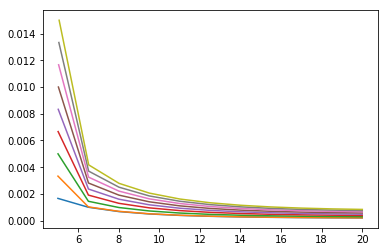

In [18]:
import numpy as np
import matplotlib.pyplot as plt

t=np.arange(0.1,1,0.1)
poissons_ratio = 0.20
E = 0.2 
Inner_radius = 5
outer_radius = 20
n = 10
mu = E/(2*(1+poissons_ratio))
Lambda=poissons_ratio*E/((1-2*poissons_ratio)*(1+poissons_ratio))
volumetric_strain = -0.01
yield_stress = 200e-6 #N/micromm^2



C = np.array([[Lambda+2*mu,Lambda,Lambda],
              [Lambda,Lambda+2*mu,Lambda],
              [Lambda,Lambda,Lambda+2*mu]])

#Tangent stiffness parameters
a=np.eye(3)
c=np.outer(a,a)
Kay = 3*Lambda+2*mu
b=np.eye(9)
d=np.zeros((9,9))
d[0,0]=1; d[1,3]=1;d[2,6]=1;d[3,1]=1;d[4,4]=1;d[5,7]=1;d[6,2]=1;d[7,5]=1;d[8,8]=1
I = (1/2*(b+d))-(1/3*c)
print(I)
coordinate = np.linspace(Inner_radius,outer_radius,n+1)      #Mesh
#print(coordinate)




Global_K = np.zeros((n+1,n+1))   # Zero matrix of order (n+1,n+1) for adding elemental stiffness
Global_F_ext = np.zeros((n+1,1))
Global_plastic_strain = np.zeros((n,3,1))



d = np.linspace(0,(1/3*t[0]*(-volumetric_strain)*coordinate[0]),n+1).reshape(n+1,1) #Initial guess
  
Global_displacement = np.flip(d,0)   
#print(Global_displacement)
Reduced_displacement = np.delete(Global_displacement,(0),axis=0)


for time,tau in enumerate(t):
    Global_displacement[0]=1/3*tau*(-volumetric_strain)*Inner_radius
    print(time+1)
#     print("GLOB:",Global_displacement)
    delta_u = 1
    plastic_strain = np.zeros((n,3,1))
    while np.linalg.norm(delta_u)>(0.005*np.linalg.norm(Reduced_displacement)):
        for i in range(len(coordinate)-1):

            def element_routine(coordinate,Lambda,mu,tau,i):
                Derivative_N = np.array([-1/2,1/2])
                Jacobian = Derivative_N@np.array([[coordinate[i]],
                                                  [coordinate[i+1]]])
                J_inv = np.asscalar(1/Jacobian)

                B = np.array([[-1/2*J_inv,1/2*J_inv],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])


                B_T = np.transpose(B)
                Element_stiffness = 2*(B_T@material_routine(E,i)@B)*Jacobian*((coordinate[i]+coordinate[i+1])/2)**2

                #External force calculation
                sigma_rr = 2*mu*J_inv*((-Global_displacement[i]+Global_displacement[i+1])/2)+Lambda*tau*volumetric_strain

                Fe = np.array([[-np.asscalar(sigma_rr)*coordinate[i]**2],
                                [np.asscalar(sigma_rr)*coordinate[i+1]**2]])
                return Element_stiffness


            def material_routine(E,i):
                Derivative_N = np.array([-1/2,1/2])
                Jacobian = Derivative_N@np.array([[coordinate[i]],
                                                  [coordinate[i+1]]])
                J_inv = np.asscalar(1/Jacobian)

                B_matrix = np.array([[-1/2*J_inv,1/2*J_inv],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])

                Current_strain = B_matrix@np.array([Global_displacement[i],Global_displacement[i+1]]) 

                
                Trial_stress = C@(Current_strain - Global_plastic_strain[i])
                Trial_dev = Trial_stress - 1/3*np.sum(Trial_stress)
                Trial_eq = np.sqrt(3/2*(np.sum(np.square(Trial_dev))))
                #print('eq',Trial_eq)
                dev_tensor = np.diagflat(Trial_dev)
                
                dev_outer = np.outer(dev_tensor,dev_tensor)
              #  print(dev_outer)
              #  print("TRIAL:",Trial_eq)
              #  print(yield_stress)
                if Trial_eq - yield_stress < 0:
                    return C
                else:
                    del_lamda = (Trial_eq - yield_stress)/(3*mu)
                    #print('del_l',del_lamda)
                    plastic_strain[i] = Global_plastic_strain[i] + del_lamda * 1.5 * (Trial_dev/Trial_eq)
                    new_stress = C@(Current_strain-plastic_strain[i])
                    
                    new_dev = new_stress - 1/3*np.sum(new_stress)
                    new_eq = np.sqrt(3/2*(np.sum(np.square(new_dev))))
                    print('new',new_eq,i)
                    tangent_stiffness = Kay/3*(c)+2*mu*((Trial_eq-3*mu*del_lamda)/Trial_eq)*I-(3*mu*(1/Trial_eq**2)*dev_outer)
                    skip = tangent_stiffness[0::4]
                    C_t = skip[np.nonzero(skip)].reshape(3,3)
                    #print(C_t)
                    return C_t
#             print("I_out:",i)
            Ke = element_routine(coordinate,Lambda,mu,tau,i)
            #Assignmnet matrix
            Ae = np.zeros((2,n+1))
            Ae[0,i]=1                                            # [0,n-1]=1 [1,n]=1
            Ae[1,i+1]  =1
            AeT = np.transpose(Ae)


            #Global stiffness matrix
            K=AeT@Ke@Ae                                          # Stiffness matrix  of each element after transformation
            Global_K = np.add(Global_K,K)  # Global stiffnes matrix
          
        K_red = np.delete(Global_K,(0),axis=0)
        K_red = np.delete(K_red,(0),axis=1)



           #F_ext = AeT@Fe_ext                                   # Force vector of each element after transformation
           #Global_F_ext=np.add(Global_F_ext,F_ext)              # Global F matrix
        Global_F_ext = np.zeros((n+1,1))
        Global_F_ext[-1]=0                                   # Global F matrix

           



        #Newton Raphson method

        #print(Global_K)
        G_matrix = Global_K@Global_displacement - Global_F_ext

        G_red = np.delete(G_matrix,(0),axis=0)
        delta_u = np.linalg.inv(K_red)@G_red
        Reduced_displacement = Reduced_displacement - delta_u
        
        Global_displacement = np.insert(Reduced_displacement,(0),(1/3*(tau)*(-volumetric_strain)*Inner_radius)).reshape(n+1,1)
#lobal_displacement = np.insert(Reduced_displacement,(0),(1/3*(tau)*(-volumetric_strain)*Inner_radius)).reshape(n+1,1)
    Global_plastic_strain=plastic_strain
    plt.plot(coordinate,Global_displacement)
    coordinate = coordinate + (Global_displacement.reshape(n+1))

 



       
   
   
    